## PDE reconstruction using (physics-informed) feedforward neural networks
## 1. Introduction

This example illustrates how to implement a neural network (NN) and modify the loss function to introduce some physical knowledge during the training of the network.
The present case is illustrated on the Burgers' equation:
\begin{equation}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}, x\in[-1,1]
\end{equation}
with Dirichlet boundary conditions:
$$ u(-1,t) = u(1,t) = 0$$
The initial condition is:
$$u(x,0) = - \sin(\pi x)$$

In this example, we will study how to implement a NN that can estimate the solution of the PDE presented above. To this aim, we will present a general implementation of a feedforward NN.

## 2. Code

### 2.1 Imports

In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 7]
import scipy.io
from scipy.interpolate import griddata
# from pyDOE import lhs
import time
import h5py
# from Burgers_PINN import Burgers_PINN
np.random.seed(1234)
tf.set_random_seed(1234)

#### Import the PINN class
Have a look inside that notebook too

In [2]:
%run Burgers_PINN.ipynb

### 2.1 Read the data from Burgers' equation
The shock case: an initial sinusoide which evolves into a shock the initial condition is a -sin(pi*x)

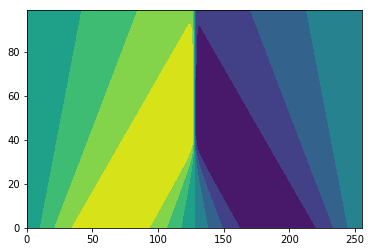

In [3]:
hf = h5py.File('./Data/burgers_shock.h5','r')
t = np.array(hf.get('/t')).T
x = np.array(hf.get('/x')).T
Exact = np.array(hf.get('/usol'))
hf.close()
nu = 0.01/np.pi
X, T = np.meshgrid(x,t)

X_all = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
Uexact_all = Exact.flatten()[:,None]              

# Domain bounds
lb = X_all.min(0)
ub = X_all.max(0)
plt.contourf(Exact)

### 2.3 Define the size of the NN
For the feedforward NN, the number of layers and of neurons per layer is one of the most important parameters.
It will describe (to some extent) the ability of the network to represent more complex function.

In [4]:
layers = [2, 20, 20, 1]
model = Burgers_PINN(layers, lb, ub, nu)


### 2.4 Training of the NN on different datasets
Here, we train the conventional NN on 2 types of data in the training dataset:
1. IBC case: Feedforward NN trained on just the knowledge of the initial and boundary conditions
2. data case: Feedforward NN trained on a random sample of data sample in the $[-1,1] \times [0,1]$ domain

For the physics informed neural network, we will also consider 2 types of data in the training dataset:
3. Physics + IBC case: Feedforward NN with the knowledge of the initial and boundary conditions and physical constraints on the residual
4. Physics + data case: Feedforward NN with a random sample of data and the physical constraints

### 2.4.1 Initial-BoundaryConditions case: Train the NN from points only on the IC and BC

In [5]:
# Uniformly distributed points in x-domain [-1,1] for the initial condition
Nx_init = 50
x_init = np.linspace(lb[0],ub[0],Nx_init)
u_x_init = - np.sin(np.pi*x_init)

X_init = np.hstack((x_init[:,None],np.zeros(len(x_init))[:,None]) )

# Uniformly distributed points in t-domain [0,1] for the left BC
Nt_BC = 50
t_BC = np.linspace(lb[1],ub[1],Nt_BC)
u_train = np.zeros(len(t_BC))
T_init = np.hstack((-np.ones(len(t_BC))[:,None],t_BC[:,None]) )
X_trainIBC = np.vstack((X_init,T_init))
u_trainIBC = np.vstack((u_x_init[:,None],np.zeros(len(t_BC))[:,None]) )

# Uniformly distributed points in t-domain [0,1] for the right BC
Nt_BC = 50
t_BC = np.linspace(lb[1],ub[1],Nt_BC)
u_train = np.zeros(len(t_BC))
T_init = np.hstack((np.ones(len(t_BC))[:,None],t_BC[:,None]) )
X_trainIBC = np.vstack((X_trainIBC,T_init))
u_trainIBC = np.vstack((u_trainIBC,np.zeros(len(t_BC))[:,None]) )

('Loss:', 0.21461102)
('Loss:', 1.5295165)
('Loss:', 0.15439557)
('Loss:', 0.14953965)
('Loss:', 0.14777799)
('Loss:', 0.14683352)
('Loss:', 0.14534874)
('Loss:', 0.14058785)
('Loss:', 0.125179)
('Loss:', 0.11491113)
('Loss:', 0.08909987)
('Loss:', 0.06865)
('Loss:', 0.04982013)
('Loss:', 0.04053015)
('Loss:', 0.030834248)
('Loss:', 0.025257235)
('Loss:', 0.022911916)
('Loss:', 0.020282492)
('Loss:', 0.019367538)
('Loss:', 0.01779814)
('Loss:', 0.016037924)
('Loss:', 0.014311746)
('Loss:', 0.011889281)
('Loss:', 0.009852236)
('Loss:', 0.008280358)
('Loss:', 0.0069991364)
('Loss:', 0.0063087847)
('Loss:', 0.0056397626)
('Loss:', 0.0054467674)
('Loss:', 0.0053972886)
('Loss:', 0.005281131)
('Loss:', 0.0047592614)
('Loss:', 0.004023195)
('Loss:', 0.003112463)
('Loss:', 0.0019153154)
('Loss:', 0.0015584227)
('Loss:', 0.0014171365)
('Loss:', 0.0013472077)
('Loss:', 0.0013008793)
('Loss:', 0.0012723401)
('Loss:', 0.0012331256)
('Loss:', 0.0011661807)
('Loss:', 0.0011142922)
('Loss:', 0.00101

(0, 1)

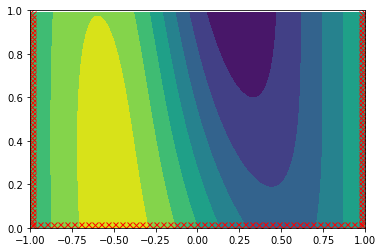

In [6]:
# Training purely based on "data" (knowledge of the solution on the boundaries)
start_time = time.time()
model.train_data(X_trainIBC[:,0:1],X_trainIBC[:,1:],u_trainIBC)
elapsed_IBC = time.time() - start_time                
print('Training time: %.4f' % (elapsed_IBC))

# Prediction from the PINN on the [-1,1]x[0,1] domain
u_pred = model.predict_u(X_all[:,0:1],X_all[:,1:])

error_u_IBC = np.linalg.norm(Uexact_all-u_pred,2)/np.linalg.norm(Uexact_all,2)
print('Error u: %e' % (error_u_IBC))

U_pred_IBC = griddata(X_all, u_pred.flatten(), (X, T), method='cubic')

plt.figure()
plt.contourf(x[:,0],t[:,0],U_pred_IBC)
plt.plot(X_trainIBC[:,0],X_trainIBC[:,1],'rx', markersize=12)
plt.xlim([-1,1])
plt.ylim([0,1])

### 2.4.2 Data-case: Train the NN from randomly distributed points in the domain

('Loss:', 0.48737448)
('Loss:', 0.56008893)
('Loss:', 0.25901315)
('Loss:', 0.2560478)
('Loss:', 0.25502408)
('Loss:', 0.25479862)
('Loss:', 0.2539677)
('Loss:', 0.24664563)
('Loss:', 0.24097231)
('Loss:', 0.23203559)
('Loss:', 0.22504498)
('Loss:', 0.21572657)
('Loss:', 0.19749877)
('Loss:', 0.6631115)
('Loss:', 0.13063772)
('Loss:', 0.15276977)
('Loss:', 0.113741025)
('Loss:', 0.090502955)
('Loss:', 1.005041)
('Loss:', 0.07503618)
('Loss:', 0.054521274)
('Loss:', 0.050676446)
('Loss:', 0.048240397)
('Loss:', 0.043603938)
('Loss:', 0.041248564)
('Loss:', 0.03925878)
('Loss:', 0.035663087)
('Loss:', 0.031499237)
('Loss:', 0.02852784)
('Loss:', 0.026143394)
('Loss:', 0.025587562)
('Loss:', 0.025057271)
('Loss:', 0.02479713)
('Loss:', 0.024458397)
('Loss:', 0.023841726)
('Loss:', 0.02314292)
('Loss:', 0.022437548)
('Loss:', 0.021236366)
('Loss:', 0.020582378)
('Loss:', 0.019558433)
('Loss:', 0.017852942)
('Loss:', 0.01753792)
('Loss:', 0.016691182)
('Loss:', 0.0149438055)
('Loss:', 0.015

('Loss:', 0.00031461494)
('Loss:', 0.0003118716)
('Loss:', 0.00031041296)
('Loss:', 0.0003092989)
('Loss:', 0.00030858748)
('Loss:', 0.0003079527)
('Loss:', 0.0003070609)
('Loss:', 0.0003225742)
('Loss:', 0.0003064568)
('Loss:', 0.0003050438)
('Loss:', 0.00030490733)
('Loss:', 0.00030419498)
('Loss:', 0.00030311776)
('Loss:', 0.00030227765)
('Loss:', 0.0003013066)
('Loss:', 0.00030075866)
('Loss:', 0.00030042522)
('Loss:', 0.00030011474)
('Loss:', 0.00029945935)
('Loss:', 0.00029890935)
('Loss:', 0.0002982074)
('Loss:', 0.0002968946)
('Loss:', 0.0002953974)
('Loss:', 0.0002932446)
('Loss:', 0.0002910493)
('Loss:', 0.00028915095)
('Loss:', 0.0002882194)
('Loss:', 0.0002871992)
('Loss:', 0.000285079)
('Loss:', 0.00028328353)
('Loss:', 0.0002807699)
('Loss:', 0.00027841164)
('Loss:', 0.0002798382)
('Loss:', 0.0002766784)
('Loss:', 0.00027399693)
('Loss:', 0.00027193222)
('Loss:', 0.00027800637)
('Loss:', 0.0002715594)
('Loss:', 0.00027081024)
('Loss:', 0.00026994155)
('Loss:', 0.000269095

('Loss:', 8.7549925e-05)
('Loss:', 8.735907e-05)
('Loss:', 8.7249966e-05)
('Loss:', 8.7191656e-05)
('Loss:', 8.703516e-05)
('Loss:', 8.678749e-05)
('Loss:', 9.051185e-05)
('Loss:', 8.668597e-05)
('Loss:', 8.639272e-05)
('Loss:', 8.6079985e-05)
('Loss:', 8.5838976e-05)
('Loss:', 8.5568994e-05)
('Loss:', 8.527123e-05)
('Loss:', 8.482687e-05)
('Loss:', 8.425911e-05)
('Loss:', 8.374169e-05)
('Loss:', 8.355284e-05)
('Loss:', 8.322232e-05)
('Loss:', 8.312726e-05)
('Loss:', 8.302272e-05)
('Loss:', 8.293038e-05)
('Loss:', 8.284008e-05)
('Loss:', 8.278066e-05)
('Loss:', 8.264948e-05)
('Loss:', 8.254567e-05)
('Loss:', 8.246334e-05)
('Loss:', 8.242221e-05)
('Loss:', 8.238849e-05)
('Loss:', 8.2256585e-05)
('Loss:', 8.212973e-05)
('Loss:', 8.188213e-05)
('Loss:', 8.1681515e-05)
('Loss:', 8.1578866e-05)
('Loss:', 8.139024e-05)
('Loss:', 8.1139435e-05)
('Loss:', 8.0925194e-05)
('Loss:', 8.0659156e-05)
('Loss:', 8.066913e-05)
('Loss:', 8.05016e-05)
('Loss:', 8.030474e-05)
('Loss:', 8.003378e-05)
('Los

('Loss:', 4.4499415e-05)
('Loss:', 4.446294e-05)
('Loss:', 4.4403838e-05)
('Loss:', 4.4350156e-05)
('Loss:', 4.4311546e-05)
('Loss:', 4.427533e-05)
('Loss:', 4.4233388e-05)
('Loss:', 4.41639e-05)
('Loss:', 4.4159082e-05)
('Loss:', 4.4121884e-05)
('Loss:', 4.4056167e-05)
('Loss:', 4.3985165e-05)
('Loss:', 4.391522e-05)
('Loss:', 4.380383e-05)
('Loss:', 4.3659038e-05)
('Loss:', 4.3549055e-05)
('Loss:', 4.3475095e-05)
('Loss:', 4.34362e-05)
('Loss:', 4.3392687e-05)
('Loss:', 4.327423e-05)
('Loss:', 4.3379732e-05)
('Loss:', 4.3223397e-05)
('Loss:', 4.3132342e-05)
('Loss:', 4.305691e-05)
('Loss:', 4.3026783e-05)
('Loss:', 4.2976444e-05)
('Loss:', 4.302875e-05)
('Loss:', 4.294666e-05)
('Loss:', 4.2912194e-05)
('Loss:', 4.2830503e-05)
('Loss:', 4.2783133e-05)
('Loss:', 4.2706557e-05)
('Loss:', 4.265029e-05)
('Loss:', 4.259804e-05)
('Loss:', 4.257746e-05)
('Loss:', 4.2542248e-05)
('Loss:', 4.2477568e-05)
('Loss:', 4.238353e-05)
('Loss:', 4.22472e-05)
('Loss:', 4.2121716e-05)
('Loss:', 4.199594

('Loss:', 2.5002262e-05)
('Loss:', 2.4882398e-05)
('Loss:', 2.4819024e-05)
('Loss:', 2.476782e-05)
('Loss:', 2.4674417e-05)
('Loss:', 2.468006e-05)
('Loss:', 2.463677e-05)
('Loss:', 2.456555e-05)
('Loss:', 2.4518431e-05)
('Loss:', 2.445898e-05)
('Loss:', 2.4441733e-05)
('Loss:', 2.4403002e-05)
('Loss:', 2.437209e-05)
('Loss:', 2.4352756e-05)
('Loss:', 2.4326542e-05)
('Loss:', 2.4292405e-05)
('Loss:', 2.4290719e-05)
('Loss:', 2.426466e-05)
('Loss:', 2.421612e-05)
('Loss:', 2.4148523e-05)
('Loss:', 2.4107709e-05)
('Loss:', 2.405092e-05)
('Loss:', 2.4000305e-05)
('Loss:', 2.3946059e-05)
('Loss:', 2.3903423e-05)
('Loss:', 2.3878023e-05)
('Loss:', 2.3831763e-05)
('Loss:', 2.3787446e-05)
('Loss:', 2.3756862e-05)
('Loss:', 2.374253e-05)
('Loss:', 2.3701736e-05)
('Loss:', 2.3646577e-05)
('Loss:', 2.3670154e-05)
('Loss:', 2.3617875e-05)
('Loss:', 2.3587385e-05)
('Loss:', 2.3554114e-05)
('Loss:', 2.3527138e-05)
('Loss:', 2.3504004e-05)
('Loss:', 2.3471057e-05)
('Loss:', 2.3449042e-05)
('Loss:', 

('Loss:', 1.3294187e-05)
('Loss:', 1.3278494e-05)
('Loss:', 1.3257922e-05)
('Loss:', 1.3248217e-05)
('Loss:', 1.32399955e-05)
('Loss:', 1.32244195e-05)
('Loss:', 1.3195412e-05)
('Loss:', 1.3186593e-05)
('Loss:', 1.3156926e-05)
('Loss:', 1.3145126e-05)
('Loss:', 1.3127006e-05)
('Loss:', 1.3108093e-05)
('Loss:', 1.3683021e-05)
('Loss:', 1.31026045e-05)
('Loss:', 1.30747685e-05)
('Loss:', 1.3045668e-05)
('Loss:', 1.3022467e-05)
('Loss:', 1.3003147e-05)
('Loss:', 1.2977619e-05)
('Loss:', 1.2924067e-05)
('Loss:', 1.2980411e-05)
('Loss:', 1.2909992e-05)
('Loss:', 1.2881917e-05)
('Loss:', 1.2945565e-05)
('Loss:', 1.2871885e-05)
('Loss:', 1.2852494e-05)
('Loss:', 1.2820556e-05)
('Loss:', 1.2767801e-05)
('Loss:', 1.27245985e-05)
('Loss:', 1.2683007e-05)
('Loss:', 1.2656733e-05)
('Loss:', 1.26336645e-05)
('Loss:', 1.2621763e-05)
('Loss:', 1.2563979e-05)
('Loss:', 1.2533324e-05)
('Loss:', 1.2505218e-05)
('Loss:', 1.2511784e-05)
('Loss:', 1.2488418e-05)
('Loss:', 1.2461472e-05)
('Loss:', 1.2416006

('Loss:', 6.6590474e-06)
('Loss:', 6.6537223e-06)
('Loss:', 6.6449784e-06)
('Loss:', 6.638062e-06)
('Loss:', 6.626444e-06)
('Loss:', 6.61685e-06)
('Loss:', 6.608743e-06)
('Loss:', 6.597273e-06)
('Loss:', 6.5963604e-06)
('Loss:', 6.58652e-06)
('Loss:', 6.5833133e-06)
('Loss:', 6.5740787e-06)
('Loss:', 6.559435e-06)
('Loss:', 6.5430495e-06)
('Loss:', 6.529647e-06)
('Loss:', 6.541473e-06)
('Loss:', 6.5236063e-06)
('Loss:', 6.5109007e-06)
('Loss:', 6.4981373e-06)
('Loss:', 6.483649e-06)
('Loss:', 6.4678156e-06)
('Loss:', 6.4442565e-06)
('Loss:', 6.423471e-06)
('Loss:', 6.470982e-06)
('Loss:', 6.416049e-06)
('Loss:', 6.4065066e-06)
('Loss:', 6.400344e-06)
('Loss:', 6.3853686e-06)
('Loss:', 6.373225e-06)
('Loss:', 6.3658413e-06)
('Loss:', 6.357992e-06)
('Loss:', 6.348979e-06)
('Loss:', 6.327328e-06)
('Loss:', 6.304813e-06)
('Loss:', 6.2807467e-06)
('Loss:', 6.2600448e-06)
('Loss:', 6.232145e-06)
('Loss:', 6.2072445e-06)
('Loss:', 6.3004186e-06)
('Loss:', 6.197151e-06)
('Loss:', 6.1782634e-06

(0, 1)

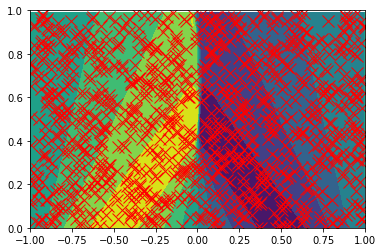

In [7]:
model.reset_weights()
# randomly picked points for the data-only training of the NN
Ntrain = 1000
idx = np.random.choice(X_all.shape[0], Ntrain, replace=False)
X_trainData = X_all[idx, :]
u_trainData = Uexact_all[idx,:]

start_time = time.time()
model.train_data(X_trainData[:,0:1],X_trainData[:,1:],u_trainData)
elapsed_Data = time.time() - start_time                
print('Training time: %.4f' % (elapsed_Data))

u_pred = model.predict_u(X_all[:,0:1],X_all[:,1:])
error_u_Data = np.linalg.norm(Uexact_all-u_pred,2)/np.linalg.norm(Uexact_all,2)
print('Error u: %e' % (error_u_Data))

U_pred_Data = griddata(X_all, u_pred.flatten(), (X, T), method='cubic')

plt.figure()
plt.contourf(x[:,0],t[:,0],U_pred_Data)
plt.plot(X_trainData[:,0],X_trainData[:,1],'rx', markersize=12)
plt.xlim([-1,1])
plt.ylim([0,1])

### 2.4.3 Phys-IBC case: Train the NN using the physical equation and the points on boundaries

### 2.4.4 Phys-Data case: Training of the PINN with random points in the domain

### 2.5 Comparison of the results and Discussion

For IBC-case, error on u at datapoints is: 9.848577e-01
For Data-case, error on u at all datapoints is: 7.773195e-02


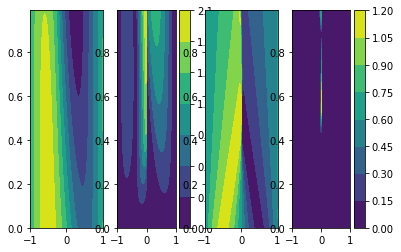

In [8]:
print('For IBC-case, error on u at datapoints is: %e' % (error_u_IBC))
print('For Data-case, error on u at all datapoints is: %e' % (error_u_Data))

plt.figure()
plt.subplot(1,4,1)
plt.contourf(x[:,0],t[:,0],U_pred_IBC)
plt.subplot(1,4,2)
plt.contourf(x[:,0],t[:,0],np.abs(U_pred_IBC-Exact))
plt.colorbar()

plt.subplot(1,4,3)
plt.contourf(x[:,0],t[:,0],U_pred_Data)
plt.subplot(1,4,4)
plt.contourf(x[:,0],t[:,0],np.abs(U_pred_Data-Exact))
plt.colorbar()
plt.show()

### 2.6 Save some results

In [9]:
fln = 'Burgers_NN_Shock_results.h5'
hf = h5py.File(fln,'w')
hf.create_dataset('U_pred_IBC',data=U_pred_IBC)
hf.create_dataset('U_pred_Data',data=U_pred_Data)
hf.create_dataset('U_Exact',data=Exact)
hf.create_dataset('x',data=x)
hf.create_dataset('t',data=t)
hf.close()